This notebook looks at detection of a simple SN Ia model in various survey strategies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils


In [2]:
import analyzeSN as ans

In [3]:
from mafContrib import SnDiscoveryMetric

We look at year=9 at most of the galactic plane etc. work is completed

In [4]:
year = 9

This is a simple SN Ia, z=0.5, stretch=1, colour=0 event from SiFTO. AB mAGS. These peak mags are in DES filters.

At z=0.5, the rise is $18d*(1+z)=27$ and we want to follow the event for about 20 days post max in the rest-frame. But we will never detect in the first few days so we just say we care about the 10 days prior to peak ie a tise of 15d observer frame.

We mock-up the rise as 2 mags over peak time, and the fall as 1.4 mags over 30 observer days in r at z=0.5

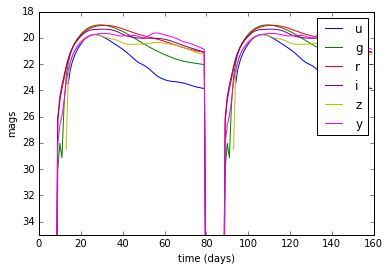

In [12]:
# Trying to make a type Ia-like 
peaks = {'uPeak':25.9, 'gPeak':23.6, 'rPeak':22.6, 'iPeak':22.7, 'zPeak':22.7,'yPeak':22.8}

colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

peakTime = 30
transDuration = 80 # Days
transMetric = SnDiscoveryMetric(riseSlope= -2./peakTime, declineSlope=1.4/30.0, 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, **peaks)


times = np.arange(0.,transDuration*2,1) 
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    bands = np.array([filterName]*times.size)
    # print(bands, transDuration, times)
    lc = transMetric.lightCurve(times % transDuration,bands)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([35,18])
plt.legend()

### What fraction are detected at least once in any filter?

In [8]:
# Pick a slicer
nside = 64
slicer = slicers.HealpixSlicer(nside=nside)
pixelArea = hp.nside2pixarea(nside, degrees=True) # in sq degrees
surveyDuration = 1. # year, since we are selection only one year in the SQL

summaryMetrics = [metrics.MedianMetric(), metrics.SumMetric()]
# Configure some metrics
metricList = []
# What fraction are detected at least once?
metricList.append(transMetric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [9]:
# Set the database and query
runName = 'enigma_1189'
sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

#### NOTE - change your path and/or opsim database here

In [10]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

In [11]:
bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint night between 3287.250000 and 3652.500000
Found 231251 visits
Running:  [0]


ValueError: Error code returned by bispev: 10

In [ ]:
bgroup.plotAll(closefigs=False)

In [ ]:
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

In [ ]:
# Now to try and compute the total number of SN detected
snRate = 0.1 #XXX--TOTALLY MADE UP NUMBER.  SNe/yr/sq Deg
sneN = bDict[0].summaryValues['Sum']*snRate*pixelArea*surveyDuration
print 'Total number of SN detected = %f' % sneN

### What fraction are detected at least 6 times in one of g r i z, 3 in first half, 3 in second half

In [ ]:
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=2, **peaks)

sqlconstraint = '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

In [ ]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

In [ ]:
bgroup.plotAll(closefigs=False)

In [ ]:
sneN = transBundle.summaryValues['Sum']*snRate*pixelArea*surveyDuration
print 'Total number of SN detected = %f' % sneN


Keywords that we need to add:

* Total number of points
* Gap time to demand between points in the same filter to count them as independent

**Let's try that again, but select only the Deep Drilling Fields**

In [ ]:
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=2, **peaks)
propids, propTags = opsdb.fetchPropInfo()
sqlDD = utils.createSQLWhere('DD', propTags)
sqlconstraint = sqlDD+' and '+ '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [ ]:
sneN = transBundle.summaryValues['Sum']*snRate*pixelArea*surveyDuration
print 'Total number of SN detected = %f' % sneN

### What fraction are detected at least 9 times in one of g r i z, 3 in each third

In [ ]:
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=3, **peaks)

sqlconstraint = '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f'% (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

In [ ]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [ ]:
sneN = transBundle.summaryValues['Sum']*snRate*pixelArea*surveyDuration
print 'Total number of SN detected = %f' % sneN